In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
import pymrmr

# Load the dataset
data = pd.read_csv("D:\shared_git\MaestriaClassess\dataAnalysis\FPA_DataAnalysis\online_shoppers_intention.csv")

In [20]:
# Identify categorical and numeric features
categorical_features = ['Month', 'VisitorType', 'Weekend']
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
if 'Revenue' in numeric_features:
    numeric_features = numeric_features.drop('Revenue')

# Create transformers for numeric and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Prepare feature matrix X and target vector y
X = data.drop('Revenue', axis=1)
y = data['Revenue']

# Apply preprocessing to the data
X_transformed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)

# Calculate Mutual Information
mi_scores = mutual_info_classif(X_train, y_train)
top_features_mi = [i for i in sorted(range(len(mi_scores)), key=lambda i: mi_scores[i], reverse=True)[:10]]  # Select top 10


In [21]:
# Calculate Mutual Information
mi_scores = mutual_info_classif(X_train, y_train)
top_features_mi = [i for i in sorted(range(len(mi_scores)), key=lambda i: mi_scores[i], reverse=True)[:10]]  # Select top 10

In [22]:
# Initialize and train the logistic regression model using features from MI
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train[:, top_features_mi], y_train)

# Prediction: get the probability of the positive class
y_pred_proba = logreg.predict_proba(X_test[:, top_features_mi])[:, 1]  # Only positive class probabilities
y_pred = logreg.predict(X_test[:, top_features_mi])


# Calculate accuracy and display classification report
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Compute AUC
auc_score = roc_auc_score(y_test, y_pred_proba)

In [23]:
# Display results
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", confusion_mat)
print(f"AUC Score: {auc_score}")


Accuracy: 0.8803730738037308
Classification Report:
               precision    recall  f1-score   support

       False       0.89      0.98      0.93      2084
        True       0.74      0.35      0.48       382

    accuracy                           0.88      2466
   macro avg       0.82      0.66      0.70      2466
weighted avg       0.87      0.88      0.86      2466

Confusion Matrix:
 [[2037   47]
 [ 248  134]]
AUC Score: 0.8829300278361186


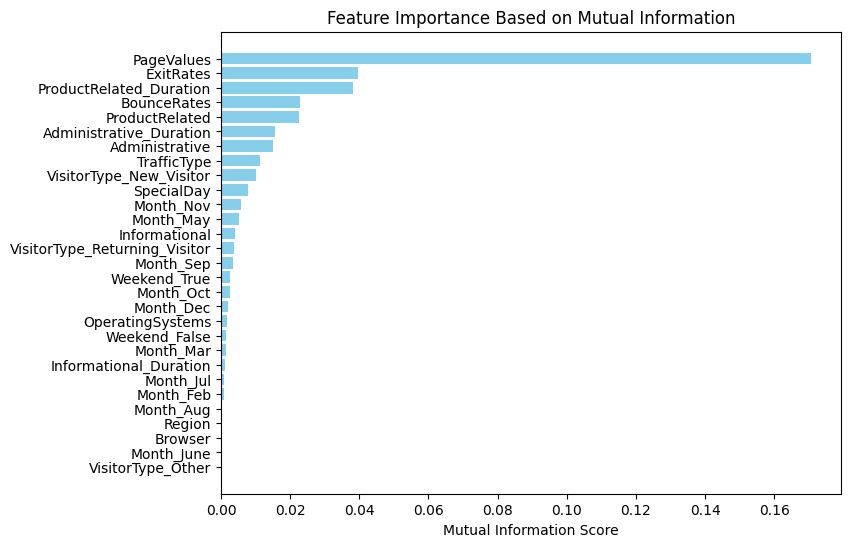

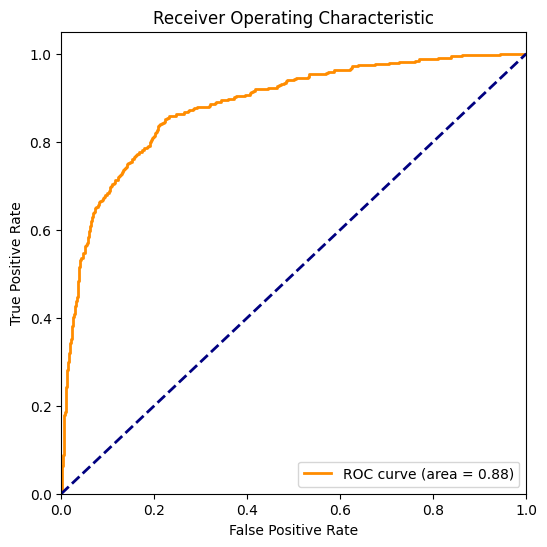

<Figure size 600x600 with 0 Axes>

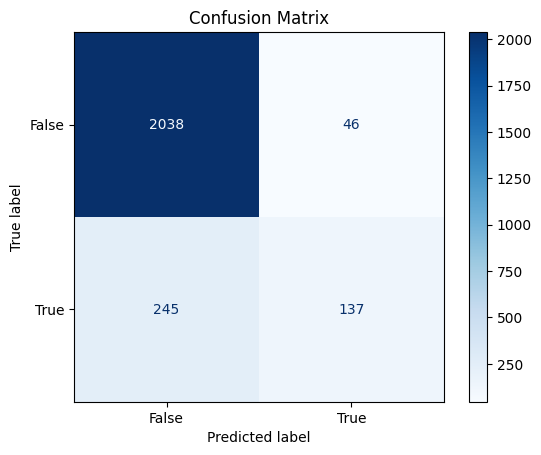

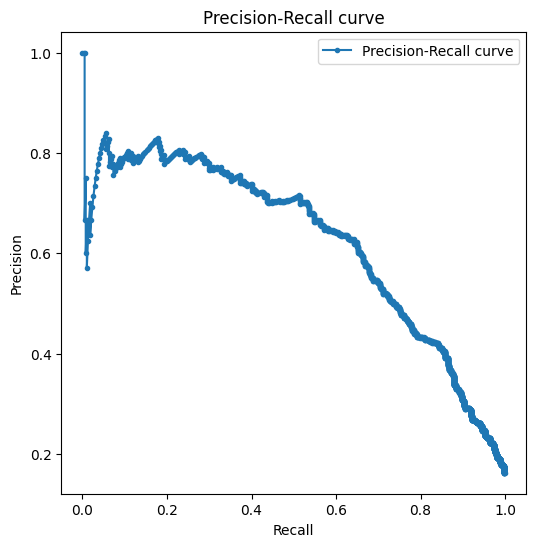

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif

# Prepare a function to get feature names from ColumnTransformer
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    output_features = []

    # Loop over all transformers
    for name, transformer, features in column_transformer.transformers_:
        if name == 'remainder':
            continue

        if hasattr(transformer, 'get_feature_names_out'):
            if isinstance(features, slice):
                features = range(X_train.shape[1])[features]
            feature_names = transformer.get_feature_names_out(features)
        else:
            feature_names = features  # for transformers without a get_feature_names_out method

        output_features.extend(feature_names)

    return output_features

# Apply the ColumnTransformer to get new feature names
X_transformed = preprocessor.fit_transform(X)
feature_names = get_feature_names(preprocessor)

# Calculate Mutual Information
mi_scores = mutual_info_classif(X_train, y_train)

# 1. Feature Importance Plot
plt.figure(figsize=(8, 6))
sorted_indices = np.argsort(mi_scores)
plt.barh(np.array(feature_names)[sorted_indices], mi_scores[sorted_indices], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance Based on Mutual Information')
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 3. Confusion Matrix Visualization
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 4. Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.show()
